<a href="https://colab.research.google.com/github/entropymator/PrimoAgent/blob/main/linera_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
import pandas as pd
import io

# Perform the file upload. This will prompt the user to select the file.
uploaded = files.upload()

# Read the uploaded CSV file into a pandas DataFrame
# Check if the expected file 'car_data.csv' is present in the uploaded dictionary.
if 'car_data.csv' in uploaded:
  df = pd.read_csv(io.StringIO(uploaded['car_data.csv'].decode('utf-8')))

  print("car_data.csv loaded successfully into DataFrame 'df'.")
  print("Displaying the first 5 rows of the DataFrame:")
  display(df.head())
else:
  print("Error: 'car_data.csv' was not found in the uploaded files. Please ensure you upload the correct file.")

Saving car_data.csv to car_data.csv
car_data.csv loaded successfully into DataFrame 'df'.
Displaying the first 5 rows of the DataFrame:


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


**Reasoning**:
To prepare the data for regression, I will first identify the target and feature variables, drop the 'name' column, and then apply one-hot encoding to the categorical features, followed by splitting the dataset into training and testing sets.



In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Define target and features
target = 'selling_price'
features = ['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner']

# 2. Create a new DataFrame without 'name' column, as specified in the instructions
df_processed = df[features + [target]].copy()

# Identify categorical features for one-hot encoding
categorical_features = ['fuel', 'seller_type', 'transmission', 'owner']

# Create a column transformer for one-hot encoding
# remainder='passthrough' ensures that non-categorical columns ('year', 'km_driven') are retained
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Apply the preprocessing steps
X = df_processed.drop(columns=[target])
y = df_processed[target]

# Apply one-hot encoding
X_encoded = preprocessor.fit_transform(X)

# Get the feature names after one-hot encoding for better interpretability
# This creates a list of column names for the transformed data
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
other_features = [col for col in X.columns if col not in categorical_features]
all_feature_names = list(encoded_feature_names) + other_features

# Convert the sparse matrix to a DataFrame for easier handling if it is sparse
# Check if X_encoded is a sparse matrix and convert if necessary
if hasattr(X_encoded, 'toarray'):
    X_encoded_df = pd.DataFrame(X_encoded.toarray(), columns=all_feature_names)
else:
    X_encoded_df = pd.DataFrame(X_encoded, columns=all_feature_names)


# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_df, y, test_size=0.2, random_state=42)

print("Data preprocessing complete.")
print(f"Original features: {X.columns.tolist()}")
print(f"Features after one-hot encoding: {X_encoded_df.columns.tolist()[:5]}...") # Displaying first 5
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Data preprocessing complete.
Original features: ['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner']
Features after one-hot encoding: ['fuel_CNG', 'fuel_Diesel', 'fuel_Electric', 'fuel_LPG', 'fuel_Petrol']...
Shape of X_train: (3472, 17)
Shape of X_test: (868, 17)
Shape of y_train: (3472,)
Shape of y_test: (868,)


In [14]:
from sklearn.linear_model import LinearRegression

# Instantiate the Linear Regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

print("Linear Regression model trained successfully.")

Linear Regression model trained successfully.


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred = linear_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Model Evaluation on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Model Evaluation on Test Set:
Mean Absolute Error (MAE): 221706.37
Mean Squared Error (MSE): 182146878750.31
R-squared (R2) Score: 0.40


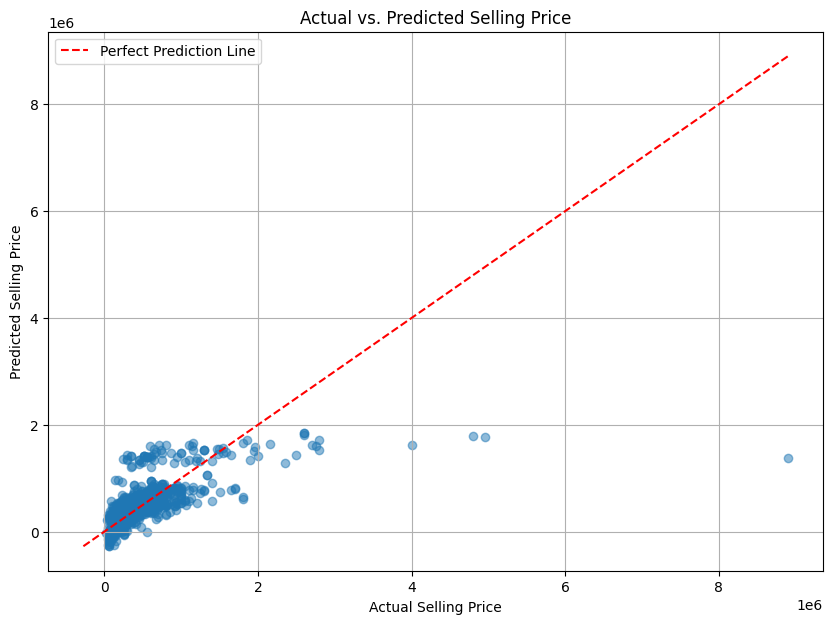

Scatter plot of actual vs. predicted selling prices displayed.


In [16]:
import matplotlib.pyplot as plt

# Create a scatter plot of actual vs. predicted selling prices
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5)

# Add a red diagonal line for perfect predictions
# The line spans from the minimum to the maximum of the actual selling prices
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction Line')

# Label the axes and add a title
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs. Predicted Selling Price')
plt.legend()
plt.grid(True)
plt.show()

print("Scatter plot of actual vs. predicted selling prices displayed.")

In [49]:
import numpy as np
x_train_w_intercept = np.hstack((np.ones((X_train.shape[0], 1)), X_train.values))

weights = np.linalg.pinv(x_train_w_intercept.T @ x_train_w_intercept) @ x_train_w_intercept.T @ y_train.values

x_test_w_intercept = np.hstack((np.ones((X_test.shape[0], 1)), X_test.values))

predicted_y = weights @ x_test_w_intercept.T

In [50]:
predicted_y-y_pred

array([ 1.61787038e+05, -1.64000452e+05,  1.14694346e+05, -1.38933376e+05,
       -8.94396482e+04, -2.28404606e+03, -1.53584399e+04, -4.39560911e+04,
       -1.01220218e+05,  6.08501023e+04,  2.51321068e+03,  5.26977604e+04,
       -1.22164229e+05,  3.11702441e+05, -8.65249429e+04, -7.42272809e+04,
       -5.69698512e+04,  8.92197842e+03,  1.43051224e+05,  7.42022443e+04,
       -2.86660053e+04, -8.85744694e+04, -1.37264515e+05, -6.71191678e+04,
        5.75611631e+04,  1.73797030e+04, -1.28266777e+05, -1.27548577e+05,
       -1.18037934e+05, -1.39326855e+05,  2.84323454e+05, -8.88577142e+04,
        5.70578494e+04, -3.07283453e+04, -1.61854922e+05,  5.89679705e+04,
       -5.10276916e+04, -1.26536864e+05,  2.99600181e+03, -1.04008798e+05,
       -1.48032495e+04, -1.28146012e+05, -4.25287612e+04,  4.39492593e+04,
       -2.38026027e+04,  7.87803980e+02, -5.37552194e+04, -1.72667378e+05,
       -1.10029771e+05, -5.00412121e+03,  1.34946045e+04, -1.35611083e+03,
       -1.94402677e+04,  

In [51]:
linear_model.coef_

array([ 6.54963086e+04,  3.45347093e+05, -5.74623031e+05,  1.18980675e+05,
        4.47989540e+04, -3.33283212e+04, -1.03147589e+05,  1.36475910e+05,
        4.45669029e+05, -4.45669029e+05, -1.36365151e+04, -1.30232942e+04,
       -4.96822287e+04,  1.17043305e+05, -4.07012669e+04,  3.57644422e+04,
       -1.00693536e+00])

In [52]:
weights

array([-2.71138286e+03,  1.23894398e+05,  3.97674604e+05, -6.41820099e+05,
        8.51947680e+04,  3.23449429e+04, -4.96517356e+04, -1.13186632e+05,
        1.60126985e+05,  4.60931273e+05, -4.63642656e+05,  4.25872395e+04,
       -1.55418391e+05, -8.74679882e+04,  3.21609202e+05, -1.24021445e+05,
        4.46384748e+02, -2.07970044e+00])

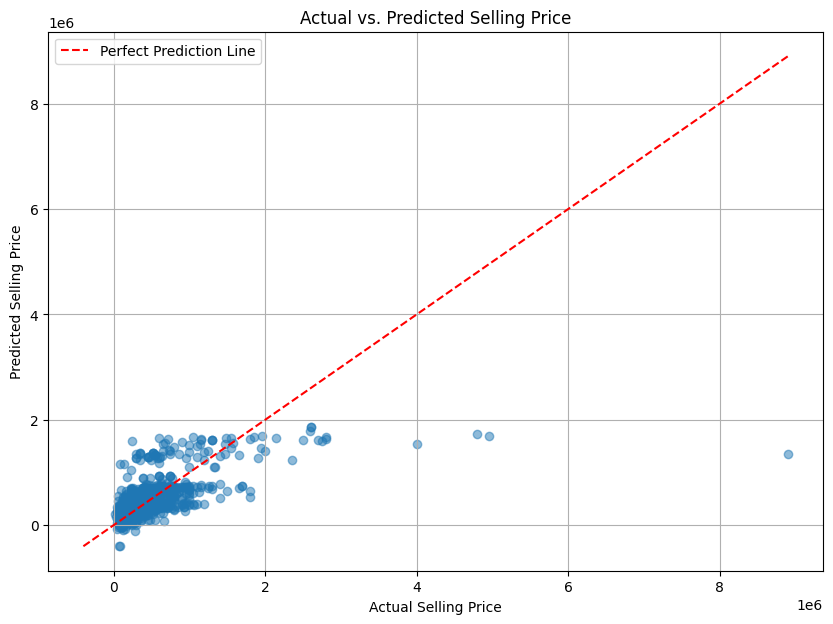

Scatter plot of actual vs. predicted selling prices displayed.


In [53]:
# Create a scatter plot of actual vs. predicted selling prices
plt.figure(figsize=(10, 7))
plt.scatter(y_test, predicted_y, alpha=0.5)

# Add a red diagonal line for perfect predictions
# The line spans from the minimum to the maximum of the actual selling prices
min_val = min(y_test.min(), predicted_y.min())
max_val = max(y_test.max(), predicted_y.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction Line')

# Label the axes and add a title
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs. Predicted Selling Price')
plt.legend()
plt.grid(True)
plt.show()

print("Scatter plot of actual vs. predicted selling prices displayed.")